## Example

In [2]:
import pandas as pd, numpy as np, sys
from sklearn.ensemble import (RandomForestClassifier, 
                              ExtraTreesClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import PercentFormatter
from AssoruleMining import *

In [3]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.grid'] = False

In [4]:
def plot_results(train, test):
    
    fig, ax = plt.subplots(figsize=(7,5))
    x = np.arange(len(train)) + 1 
    
    # Common plotting style
    base_style = dict(lw=2, solid_capstyle='round', ms=7)
    configs = [(train, "Precision", "#1B9CFC", "Train", "-", "o"),
               (test, "Precision", "#1B9CFC", "Test",  "--", "o"),
               (train, "Recall", "#FC427B", "Train", "-", "s"),
               (test, "Recall", "#FC427B", "Test", "--", "s")]
    
    for n, (data, col, color, which, ls, marker) in enumerate(configs):
        ax.plot(data[col.lower()], color=color, ls=ls, marker=None, 
                label="{} ({})".format(col, which), **base_style)
        if n==1:
            ax.fill_between(x, train["precision"], test["precision"], 
                    color="#1B9CFC", alpha=0.2, label="Precision Gap")
        elif n==3:
            ax.fill_between(x, train["recall"], test["recall"], 
                    color="#FC427B", alpha=0.2, label="Recall Gap")

    ax.set_ylabel("Precision & Recall", fontsize=13, fontweight=1000)
    ax.set_xlabel("Number of Rules", fontsize=13, fontweight=1000)
    ax.legend(loc="best", fontsize=12, framealpha=0, ncol=2, 
              columnspacing=0.5, handletextpad=0.8, 
              labelspacing=0.4, handlelength=1.5)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax.tick_params(axis='both', labelsize=13)
    plt.tight_layout()
    
    return ax

Target: class (">50K" vs "<=50K")

In [13]:
X = fetch_openml("adult", version=2, as_frame=True).frame.drop(columns=["fnlwgt", "education-num"])
y = X.pop("class").values
y = np.where(y==">50K", 1, 0)

In [14]:
X.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,NaN,Some-college,Never-married,NaN,Own-child,White,Female,0,0,30,United-States


In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   education       48842 non-null  category
 3   marital-status  48842 non-null  category
 4   occupation      46033 non-null  category
 5   relationship    48842 non-null  category
 6   race            48842 non-null  category
 7   sex             48842 non-null  category
 8   capital-gain    48842 non-null  int64   
 9   capital-loss    48842 non-null  int64   
 10  hours-per-week  48842 non-null  int64   
 11  native-country  47985 non-null  category
dtypes: category(8), int64(4)
memory usage: 1.9 MB


We use **`define_dtype`** to convert columns in `X` to possible dtypes which are `float32`, `int32`, `category`, and `object`. However, it ignores columns, whose dtype is either np.datetime64 or np.timedelta64.

In [16]:
# print(define_dtype.__doc__)

In [17]:
# X = define_dtype(X, max_category=20)
# X.info()

Convert categorical to numerical variable.

In [18]:
cat = list(X.select_dtypes(include=["category"]))
for c in cat: X[c] = X[c].cat.add_categories('missing').fillna('missing')
enc = OneHotEncoder(handle_unknown='ignore').fit(X[cat])
columns = ["{} ({})".format(*n) 
           for c,v in zip(cat, enc.categories_) 
           for n in list(product([c],v))]

In [19]:
cat_df = pd.DataFrame(enc.transform(X[cat]).toarray().astype(int), columns=columns)
cat_X  = X.drop(columns=cat).merge(cat_df, left_index=True, right_index=True)

In [20]:
Xt_train, Xt_test, yt_train, yt_test = tts(cat_X, y, test_size=0.3, shuffle=True, random_state=0)

## Creation of rules
- Extract the best path in tree that satisfies criteria.
- If **`exclude`=True**, after each iteration training samples under previously selected leaf node (path) are excluded from the training set before determining the next rule. If **`exclude`=False**, it changes target to non-target i.e. 1 to 0 while keeping the sample size the same.
- This approach stops when the evaluating metric is deemed satisfactory (`max_iter`).

In [21]:
# print(TreeRuleMining.__doc__)

### Example 1: **`DecisionTreeClassifier`**

In [39]:
kwds = dict(max_depth=None,
            max_features=Xt_train.shape[1], 
            random_state=0, 
            min_samples_leaf=0.01, 
            class_weight="balanced")
Tree1 = DecisionTreeClassifier(**kwds)

In [40]:
model1 = TreeRuleMining(Tree1, 
                        exclude=True, 
                        metric="recall", 
                        max_iter=50).fit(Xt_train, yt_train)

Apply selected rules on `X` and evaluate rule performance against `y`.

In [41]:
eval_train1 = model1.evaluate(Xt_train, yt_train, cumulative=True)
eval_test1  = model1.evaluate(Xt_test , yt_test , cumulative=True)

In [42]:
eval_train1.head()

,cum_targets,cum_samples,precision,recall
rule,,,,
1,483,492,0.981707,0.059104
2,1035,1065,0.971831,0.126652
3,1448,1579,0.917036,0.177190
4,1788,2009,0.889995,0.218796
5,2332,2779,0.839151,0.285365


Example of visualizations using **`plot_results`**

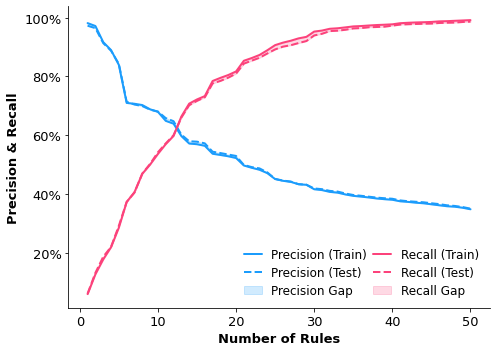

In [43]:
_ = plot_results(eval_train1, eval_test1)

See all selected rules and their subrules using **`print_rule`**.

In [27]:
n_rules = 5
for n in np.arange(n_rules)+1:
    print(key:=f"Rule_{n}")
    print_rule(model1.rules[key])
    print()

Rule_1
Operator:  and
+------+-------------------------------------+------+-----------+
| Item | Variable                            | Sign |     Value |
+------+-------------------------------------+------+-----------+
|  1   | marital-status (Married-civ-spouse) |  >   |      0.50 |
|  2   | capital-gain                        |  >   |  5,095.50 |
|  3   | age                                 |  <=  |     51.50 |
|  4   | capital-gain                        |  <=  | 11,356.00 |
+------+-------------------------------------+------+-----------+

Rule_2
Operator:  and
+------+-------------------------------------+------+----------+
| Item | Variable                            | Sign |    Value |
+------+-------------------------------------+------+----------+
|  1   | marital-status (Married-civ-spouse) |  >   |     0.50 |
|  2   | age                                 |  >   |    29.50 |
|  3   | capital-gain                        |  >   | 5,095.50 |
|  4   | age                         

Use **`self.transform`** to convert rules into features array.

In [28]:
model1.transform(Xt_train, n_rules).head()

,Rule_1,Rule_2,Rule_3,Rule_4,Rule_5
0,False,False,False,False,False
1,False,False,False,False,False
2,True,True,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False


Summary on `Xt_train` using **`print_stats`**

In [29]:
yt_pred_train = model1.transform(Xt_train, n_rules).sum(1)>0
print_stats(yt_train, yt_pred_train)

+----------------+--------+-------+
| Statistics     |  Value |     % |
+----------------+--------+-------+
| N              | 34,189 |       |
| Target         |  8,172 | 23.9% |
| True Positive  |  1,721 |  5.0% |
| True Negative  | 25,769 | 75.4% |
| False Positive |    248 |  0.7% |
| False Negative |  6,451 | 18.9% |
| Precision      |        | 87.4% |
| Recall         |        | 21.1% |
| Accuracy       |        | 80.4% |
| F1-Score       |        | 33.9% |
+----------------+--------+-------+


In [30]:
yt_pred_test = model1.transform(Xt_test, n_rules).sum(1)>0
print_stats(yt_test, yt_pred_test)

+----------------+--------+-------+
| Statistics     |  Value |     % |
+----------------+--------+-------+
| N              | 14,653 |       |
| Target         |  3,515 | 24.0% |
| True Positive  |    762 |  5.2% |
| True Negative  | 11,038 | 75.3% |
| False Positive |    100 |  0.7% |
| False Negative |  2,753 | 18.8% |
| Precision      |        | 88.4% |
| Recall         |        | 21.7% |
| Accuracy       |        | 80.5% |
| F1-Score       |        | 34.8% |
+----------------+--------+-------+


### Example 2: **`RandomForestClassifier`**

In [31]:
kwds = dict(n_estimators=20,
            max_depth=None,  
            min_samples_leaf=0.01,
            max_features="sqrt", 
            random_state=0, 
            bootstrap=True)
Tree2 = RandomForestClassifier(**kwds)

In [32]:
model2 = TreeRuleMining(Tree2, 
                        exclude=True, 
                        metric="recall", 
                        max_iter=50).fit(Xt_train, yt_train)

In [33]:
eval_train2 = model2.evaluate(Xt_train, yt_train, cumulative=True)
eval_test2  = model2.evaluate(Xt_test , yt_test , cumulative=True)

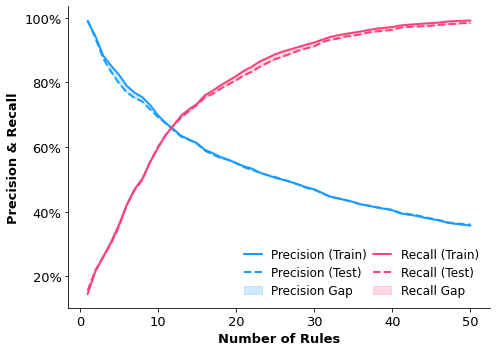

In [34]:
_ = plot_results(eval_train2, eval_test2)

### Example 3: **`ExtraTreesClassifier`** 

In [35]:
kwds = dict(n_estimators=20, 
            criterion="gini",
            max_depth=None,  
            min_samples_leaf=0.01,
            max_features="sqrt", 
            random_state=0, 
            bootstrap=True, 
            monotonic_cst=[1]*Xt_train.shape[1])
Tree3 = ExtraTreesClassifier(**kwds)

In [36]:
model3 = TreeRuleMining(Tree3, 
                        exclude=True, 
                        metric="recall", 
                        max_iter=50).fit(Xt_train, yt_train)

In [37]:
eval_train3 = model3.evaluate(Xt_train, yt_train, cumulative=True)
eval_test3  = model3.evaluate(Xt_test , yt_test , cumulative=True)

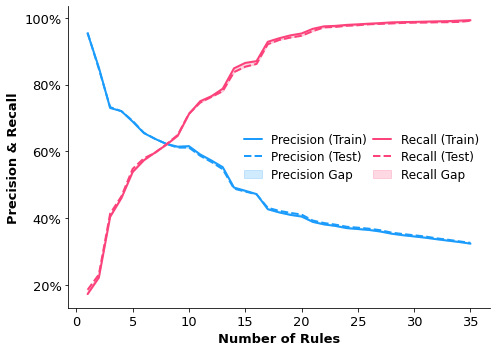

In [38]:
_ = plot_results(eval_train3, eval_test3)